<a href="https://colab.research.google.com/github/Felixphz/Proyecto-Modelos/blob/main/04%20-%20preprocesado%20entrega%20final%20con%20XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extrayendo Información desde Kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 ./kaggle.json
!kaggle competitions download -c udea-ai4eng-20242

 89% 18.0M/20.1M [00:00<00:00, 85.9MB/s]
100% 20.1M/20.1M [00:00<00:00, 88.3MB/s]


In [ ]:
!unzip udea*.zip > /dev/null
!wc *.csv

   296787    296787   4716673 submission_example.csv
   296787   4565553  50135751 test.csv
   692501  10666231 118025055 train.csv
  1286075  15528571 172877479 total


# Importaciones e Instalaciones necesarias.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Clase para la generación del modelo

La clase **StudentPerformanceXGBoostClassifier** está diseñada para predecir el rendimiento académico de los estudiantes a partir de diversos datos demográficos y socioeconómicos. Utiliza el modelo de clasificación **XGBooost** para realizar las predicciones. La clase implementa un proceso completo de preprocesamiento de datos, que incluye la creación de características a partir de la educación de los padres, el estrato socioeconómico, la matrícula universitaria y otros factores relacionados con los programas académicos y los departamentos de los estudiantes. Además, la clase incluye técnicas de codificación dirigida (target encoding) para mejorar la representación de categorías en las variables. El modelo entrenado se evalúa a través de métricas de clasificación, como el reporte de clasificación y la matriz de confusión, y proporciona una visualización de la importancia de las características utilizadas en el modelo.

In [ ]:
class StudentPerformanceXGBoostClassifier:
    """
      Clasificador de rendimiento académico utilizando XGBoost.
      Esta clase implementa un modelo de clasificación multiclase para predecir el rendimiento
      académico de estudiantes basado en características socioeconómicas y académicas.
    """
    def __init__(self):
        self.model = None
        self.feature_importance = None
        self.label_encoders = {}
        self.performance_encoder = LabelEncoder()
        self.df_train = None
        self.df_test = None

    def _encode_categorical_features(self, df, training=False):
        """
        Codifica las características categóricas utilizando LabelEncoder.
        A diferencia de CatBoost, XGBoost requiere que todas las variables categóricas
        sean convertidas a numéricas explícitamente.
        """
        df = df.copy()

        categorical_columns = [
            'ESTU_PRGM_ACADEMICO',
            'ESTU_PRGM_DEPARTAMENTO',
            'ESTU_VALORMATRICULAUNIVERSIDAD',
            'ESTU_HORASSEMANATRABAJA',
            'FAMI_ESTRATOVIVIENDA',
            'FAMI_TIENEINTERNET',
            'FAMI_EDUCACIONPADRE',
            'FAMI_EDUCACIONMADRE',
            'ESTU_PAGOMATRICULAPROPIO'
        ]

        for column in categorical_columns:
            if training:
                self.label_encoders[column] = LabelEncoder()
                df[column] = self.label_encoders[column].fit_transform(df[column].fillna('No reporta'))
            else:
                df[column] = self.label_encoders[column].transform(df[column].fillna('No reporta'))

        return df

    def create_education_features(self, df):
        """
        Generamos características basadas en el nivel educativo de los padres del estudiante.

        Esta función convierte los niveles educativos a valores numéricos y crea características
        derivadas que representan la situación educativa familiar.

        DataFrame con las nuevas características agregadas:
                - FAMI_EDUCACIONPADRE_NUM: Nivel educativo del padre (numérico)
                - FAMI_EDUCACIONMADRE_NUM: Nivel educativo de la madre (numérico)
                - FAMI_EDUCACION_PROMEDIO: Promedio educativo de ambos padres
                - FAMI_EDUCACION_DIFERENCIA: Diferencia absoluta entre niveles educativos
                - FAMI_EDUCACION_MAX: Máximo nivel educativo entre los padres
                - FAMI_EDUCACION_MIN: Mínimo nivel educativo entre los padres
        """
        education_mapping = {
            'Ninguno': 0,
            'Primaria incompleta': 1,
            'Primaria completa': 2,
            'Secundaria (Bachillerato) incompleta': 3,
            'Secundaria (Bachillerato) completa': 4,
            'Técnica o tecnológica incompleta': 5,
            'Técnica o tecnológica completa': 6,
            'Educación profesional incompleta': 7,
            'Educación profesional completa': 8,
            'Postgrado': 9,
            'No sabe': 4,
            'No Aplica': 4,
            'No reporta': 4
        }

        # Rellenar NaN antes de hacer el mapping
        df['FAMI_EDUCACIONPADRE'] = df['FAMI_EDUCACIONPADRE'].fillna('No reporta')
        df['FAMI_EDUCACIONMADRE'] = df['FAMI_EDUCACIONMADRE'].fillna('No reporta')

        df['FAMI_EDUCACIONPADRE_NUM'] = df['FAMI_EDUCACIONPADRE'].map(education_mapping)
        df['FAMI_EDUCACIONMADRE_NUM'] = df['FAMI_EDUCACIONMADRE'].map(education_mapping)

        # Generar nuevas features
        df['FAMI_EDUCACION_PROMEDIO'] = (df['FAMI_EDUCACIONPADRE_NUM'] + df['FAMI_EDUCACIONMADRE_NUM']) / 2
        df['FAMI_EDUCACION_DIFERENCIA'] = abs(df['FAMI_EDUCACIONPADRE_NUM'] - df['FAMI_EDUCACIONMADRE_NUM'])
        df['FAMI_EDUCACION_MAX'] = df[['FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM']].max(axis=1)
        df['FAMI_EDUCACION_MIN'] = df[['FAMI_EDUCACIONPADRE_NUM', 'FAMI_EDUCACIONMADRE_NUM']].min(axis=1)

        return df

    def create_economic_features(self, df):
        """
        Generamos características basadas en la condición económica del estudiante.

        Esta función convierte variables categóricas económicas a valores numéricos y
        crea un score socioeconómico ponderado basado en estrato, matrícula e internet.

         DataFrame con las nuevas características agregadas:
                - FAMI_ESTRATO_NUM: Estrato socioeconómico (numérico)
                - MATRICULA_NUM: Valor de matrícula (numérico)
                - INTERNET_BIN: Indicador binario de acceso a internet
                - SCORE_SOCIOECONOMICO: Puntuación ponderada de condición económica
        """
        estrato_mapping = {
            'Estrato 1': 1,
            'Estrato 2': 2,
            'Estrato 3': 3,
            'Estrato 4': 4,
            'Estrato 5': 5,
            'Estrato 6': 6,
            'Sin Estrato': 0,
            'No reporta': 3
        }

        matricula_mapping = {
            'Menos de 500 mil': 0,
            'Entre 500 mil y menos de 1 millón': 1,
            'Entre 1 millón y menos de 2.5 millones': 2,
            'Entre 2.5 millones y menos de 4 millones': 3,
            'Entre 4 millones y menos de 5.5 millones': 4,
            'Entre 5.5 millones y menos de 7 millones': 5,
            'Más de 7 millones': 6,
            'No pagó matrícula': 0,
            'No reporta': 3
        }

        # Rellenar NaN antes de hacer el mapping
        df['FAMI_ESTRATOVIVIENDA'] = df['FAMI_ESTRATOVIVIENDA'].fillna('No reporta')
        df['ESTU_VALORMATRICULAUNIVERSIDAD'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna('No reporta')
        df['FAMI_TIENEINTERNET'] = df['FAMI_TIENEINTERNET'].fillna('No reporta')

        df['FAMI_ESTRATO_NUM'] = df['FAMI_ESTRATOVIVIENDA'].map(estrato_mapping)
        df['MATRICULA_NUM'] = df['ESTU_VALORMATRICULAUNIVERSIDAD'].map(matricula_mapping)
        df['INTERNET_BIN'] = (df['FAMI_TIENEINTERNET'] == 'Si').astype(int)

        # Generar nueva feature
        df['SCORE_SOCIOECONOMICO'] = (
            df['FAMI_ESTRATO_NUM'] * 0.4 +
            df['MATRICULA_NUM'] * 0.4 +
            df['INTERNET_BIN'] * 0.2
        )

        return df

    def preprocess_data(self, data):
        """
        Preprocesamos los datos incluyendo feature engineering y codificación de variables categóricas.
        """
        X = data.copy()
        y = X.pop('RENDIMIENTO_GLOBAL')

        # Rellenar NaN en todas las columnas categóricas primero
        categorical_columns = [
            'ESTU_PRGM_ACADEMICO',
            'ESTU_PRGM_DEPARTAMENTO',
            'ESTU_VALORMATRICULAUNIVERSIDAD',
            'ESTU_HORASSEMANATRABAJA',
            'FAMI_ESTRATOVIVIENDA',
            'FAMI_TIENEINTERNET',
            'FAMI_EDUCACIONPADRE',
            'FAMI_EDUCACIONMADRE',
            'ESTU_PAGOMATRICULAPROPIO'
        ]

        for col in categorical_columns:
            X[col] = X[col].fillna('No reporta')

        # Crear features
        X = self.create_education_features(X)
        X = self.create_economic_features(X)

        # Codificar variables categóricas
        for col in categorical_columns:
            self.label_encoders[col] = LabelEncoder()
            X[col] = self.label_encoders[col].fit_transform(X[col])

        # Codificar variable objetivo
        y = self.performance_encoder.fit_transform(y)

        # Split de datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Eliminar columnas innecesarias
        columns_to_drop = ['ID'] + [col for col in X_train.columns if col.endswith('_NUM')]
        X_train = X_train.drop(columns=columns_to_drop)
        X_test = X_test.drop(columns=columns_to_drop)

        # Guardar datos de entrenamiento para visualización
        self.df_train = X_train

        return X_train, X_test, y_train, y_test

    def train_model(self, X_train, y_train):
        """
        Entrenamos el modelo utilizando XGBoost classifier donde se definen los parámetros.s
        """
        self.model = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=4,
            learning_rate=0.1,
            max_depth=7,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            n_estimators=1000,
            random_state=42,
            early_stopping_rounds=50
        )

        eval_set = [(X_train, y_train)]
        self.model.fit(
            X_train, y_train,
            eval_set=eval_set,
            verbose=100
        )

        self.feature_importance = self.model.feature_importances_

    def evaluate_model(self, X_test, y_test):
        """
        Evaluamos el modelo, generando el reporte de clasificación y la matriz de confusión.
        """
        predictions = self.model.predict(X_test)

        # Convertir predicciones numericas a las clases otra vez.
        predictions_original = self.performance_encoder.inverse_transform(predictions)
        y_test_original = self.performance_encoder.inverse_transform(y_test)

        report = classification_report(y_test_original, predictions_original)
        cm = confusion_matrix(y_test_original, predictions_original)

        return report, cm

    def plot_feature_importance(self):
        """
        Visualización de la importancia de las características.
        """
        importance_df = pd.DataFrame({
            'feature': self.df_train.columns,
            'importance': self.feature_importance
        })
        importance_df = importance_df.sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=importance_df)
        plt.title('Feature Importance in Academic Performance')
        plt.tight_layout()
        return plt.gcf()

    def prepare_prediction_data(self, X):
        """
        Prepara datos nuevos para predicción, manejando categorías no vistas
        """
        X = X.copy()

        # Eliminar columnas que no estaban en el entrenamiento
        if 'Unnamed: 0' in X.columns:
            X = X.drop('Unnamed: 0', axis=1)
        if 'ID' in X.columns:
            X = X.drop('ID', axis=1)

        # Rellenar NaN en todas las columnas categóricas
        categorical_columns = [
            'ESTU_PRGM_ACADEMICO',
            'ESTU_PRGM_DEPARTAMENTO',
            'ESTU_VALORMATRICULAUNIVERSIDAD',
            'ESTU_HORASSEMANATRABAJA',
            'FAMI_ESTRATOVIVIENDA',
            'FAMI_TIENEINTERNET',
            'FAMI_EDUCACIONPADRE',
            'FAMI_EDUCACIONMADRE',
            'ESTU_PAGOMATRICULAPROPIO'
        ]

        # Rellenar NaN
        for col in categorical_columns:
            X[col] = X[col].fillna('No reporta')

        # Aplicar feature engineering
        X = self.create_education_features(X)
        X = self.create_economic_features(X)

        # Codificar variables categóricas
        for col in categorical_columns:
            known_categories = set(self.label_encoders[col].classes_)
            mode_category = self.label_encoders[col].classes_[0]
            X[col] = X[col].map(lambda x: mode_category if x not in known_categories else x)
            X[col] = self.label_encoders[col].transform(X[col])

        # Eliminar columnas innecesarias
        columns_to_drop = [col for col in X.columns if col.endswith('_NUM')]
        X = X.drop(columns=columns_to_drop)

        return X

    def predict(self, X):
        """
        Realiza predicción de clases para nuevos datos.
        """
        if self.model is None:
            raise ValueError("Model has not been trained")

        X_prepared = self.prepare_prediction_data(X)
        predictions = self.model.predict(X_prepared)

        # Convertir predicciones numericas a las clases otra vez.
        return self.performance_encoder.inverse_transform(predictions)

    def save_predictions(self, X, output_file):
        """
        Guarda predicciones en un archivo con ID y clase.
        """
        self.df_test = X.copy()
        predictions = self.predict(X)

        results = pd.DataFrame({
            'ID': self.df_test['ID'],
            'RENDIMIENTO_GLOBAL': predictions
        })

        results.to_csv(output_file, index=False)
        return results

# Uso de la Clase

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
# Se inicializa una objeto de la classe y empezamos el preprocesado
classifier = StudentPerformanceXGBoostClassifier()
X_train, X_test, y_train, y_test = classifier.preprocess_data(data)

Forma final de los datos para entrenar

In [ ]:
classifier.df_train.head()

,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO,FAMI_EDUCACION_PROMEDIO,FAMI_EDUCACION_DIFERENCIA,FAMI_EDUCACION_MAX,FAMI_EDUCACION_MIN,INTERNET_BIN,SCORE_SOCIOECONOMICO
503557,20183,229,4,0,4,1,2,10,10,2,3.0,0,3,3,1,1.8
145156,20212,317,4,0,5,6,1,4,4,0,4.0,0,4,4,0,2.0
224208,20203,410,4,2,2,1,2,5,9,0,4.0,0,4,4,1,2.6
103009,20183,94,3,4,1,2,2,9,9,2,4.0,0,4,4,1,1.8
273179,20183,249,10,1,0,0,2,8,9,0,2.5,3,4,1,1,1.8


In [ ]:
# Se empieza el entrenamiento
classifier.train_model(X_train, y_train)

[0]	validation_0-mlogloss:1.37130
[100]	validation_0-mlogloss:1.19464
[200]	validation_0-mlogloss:1.17141
[300]	validation_0-mlogloss:1.15643
[400]	validation_0-mlogloss:1.14456
[500]	validation_0-mlogloss:1.13420
[600]	validation_0-mlogloss:1.12496
[700]	validation_0-mlogloss:1.11611
[800]	validation_0-mlogloss:1.10772
[900]	validation_0-mlogloss:1.09973
[999]	validation_0-mlogloss:1.09217


# Evaluación del Modelo

Una vez realizada la evaluación del modelo, nos podemos dar cuenta que a pesar de la ingeniería de características utilizada aún existe confusión en el mismo para la predicción de las clases medio-alto y medio-bajo, el modelo se desempeña mejor en las clases extremas. Lo cual también se valida en la matrix de confusión.

Nota:Este modelo tuvo un desempeño menor con respecto al CatBoost a pesar de tener el mismo preprocesado (casi idéntico, la diferencia radica que aquí todas las features fueron convertidas a número antes del entrenamiento)


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.56      0.62      0.59     35124
        bajo       0.47      0.55      0.50     34597
  medio-alto       0.33      0.28      0.30     34324
  medio-bajo       0.33      0.29      0.31     34455

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.43    138500
weighted avg       0.42      0.43      0.43    138500


Matriz de Confusión:


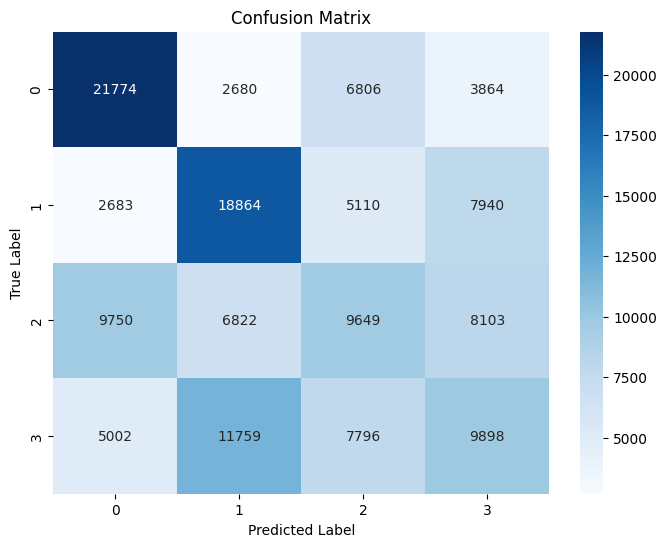

In [ ]:
report, cm = classifier.evaluate_model(X_test, y_test)

print("\nReporte de Clasificación:")
print(report)
print("\nMatriz de Confusión:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Prueba con los datos de envío

In [ ]:
X_test = pd.read_csv('test.csv')

In [ ]:
X_test.head()

,Unnamed: 0,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_PRGM_DEPARTAMENTO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,ESTU_PAGOMATRICULAPROPIO
0,0,550236,20183,TRABAJO SOCIAL,BOLIVAR,Menos de 500 mil,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica completa,Primaria completa,Si
1,1,98545,20203,ADMINISTRACION COMERCIAL Y DE MERCADEO,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Técnica o tecnológica completa,No
2,2,499179,20212,INGENIERIA MECATRONICA,BOGOTÁ,Entre 1 millón y menos de 2.5 millones,0,Estrato 3,Si,Secundaria (Bachillerato) incompleta,Secundaria (Bachillerato) completa,No
3,3,782980,20195,CONTADURIA PUBLICA,SUCRE,Entre 1 millón y menos de 2.5 millones,Entre 21 y 30 horas,Estrato 1,No,Primaria incompleta,Primaria incompleta,No
4,4,785185,20212,ADMINISTRACION DE EMPRESAS,ATLANTICO,Entre 2.5 millones y menos de 4 millones,Entre 11 y 20 horas,Estrato 2,Si,Secundaria (Bachillerato) completa,Secundaria (Bachillerato) completa,No


In [ ]:
# Hacer y guardar predicciones
results = classifier.save_predictions(X_test, 'my_submission.csv')

In [ ]:
results

,ID,RENDIMIENTO_GLOBAL
0,550236,bajo
1,98545,medio-alto
2,499179,alto
3,782980,bajo
4,785185,bajo
...,...,...
296781,496981,medio-bajo
296782,209415,alto
296783,239074,medio-alto
296784,963852,alto
